# Introducing Microsoft LIDA 

[Microsoft LIDA](https://github.com/microsoft/lida) is an open-source Python library for the _automatic generation of data visualizations and data-faithful infographics_ using Large Language Models.  

LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, Azure OpenAI, PaLM, Cohere, Huggingface). 
 * 🔬 | | Read [this paper](https://browse.arxiv.org/pdf/2303.02927.pdf) for more details on the research
 * 📗 | See [this notebook](https://github.com/microsoft/lida/blob/main/notebooks/tutorial.ipynb) for a sample tutorial.
 * 💻 | Check out [this website](https://microsoft.github.io/lida/) for project updates.
 * ⭐️ | Star [this repo](https://github.com/microsoft/lida) if you like the project.
 * 📽 | Watch [this video](https://vimeo.com/820968433) for a quick walkthrough of LIDA in action.

---



## 1. Getting Started: [LIDA on Codespaces](https://github.com/lida-project/lida-codespaces) 

The [lida-codespaces](https://github.com/lida-project/lida-codespaces) template is set up with 
 - a [dev container](https://containers.dev) configuration that uses
 - the [Microsoft Universal](https://mcr.microsoft.com/en-us/product/devcontainers/universal/about) container image and 
 - uses `.devcontainer/requirements.txt` to install Python package dependencies including `lida`

If you intend to use lida with local huggingface models, you will need the `transformers` library. 
 - this is currently installed post container creation (see `.devcontainer/post-create-command.sh`)

This means your development environment is already set for using `lida`. You can just dive straight into writing your applications.

---

## 2. Getting Started: OpenAI/LLM API Keys

This requires two things:
 - an OPENAI_API_KEY set in your environment variables.
 - the `openai` package installed in the development environment.

The second requirement is taken care of for you in the development container. 

To set the OPENAI_API_KEY you have two options based on where you run the dev container
 - Using GitHub Codespaces? Then [set this up as a codespaces secret](https://docs.github.com/en/codespaces/managing-your-codespaces/managing-secrets-for-your-codespaces).
 - Using Docker Desktop? Then copy `.env.copy` into a `.env` file in repo root, and fill in the required LLM keys

Once you do this, running the development container will make those environment variables available to your notebooks for use.

---

## 3. Troubleshooting: ModuleNotFoundError

When running in a dev container (vs. your own local installed environment) you may encounter this error message:

```bash
ModuleNotFoundError: No module named '_lzma'
```

This seems to be a frequently-encountered issue. Python 3.3 and later should provide this module by default - but in some cases the _lzma-dev_ packagte is not installed correctly and the module does not seem to resolve for imports. After multiple trial-and-error runs, the [approach defined in this article](https://support.huawei.com/enterprise/en/doc/EDOC1100289998/db0db8f0/modulenotfounderror-no-module-named-_lzma-) seemed to work to fix the issue.

Steps are:

1. Install the `liblzma-dev` system dependency first | 👉🏽  `sudo apt-get install -y liblzma-dev`
2. Install the `lzma` Python module next | 👉🏽  `pip3 install backports.lzma`
3. Modify the system `lzma.py` file to handle error | 👉🏽  `vi /usr/local/python/3.10.8/lib/python3.10/lzma.py`

In that file replace:

```python
from _lzma import *
from _lzma import _encode_filter_properties, _decode_filter_properties
```

With:

```python
try:
    from _lzma import *
    from _lzma import _encode_filter_properties, _decode_filter_properties
except ImportError:
    from backports.lzma import *
    from backports.lzma import _encode_filter_properties, _decode_filter_properties
```

Save the changes. Now clear outputs in your Notebook and `Run all` again. 
The issue should resolve.

🚨 | This is not ideal - the real solution is to find the right Python devcontainer image that has the `lzma` installation done correctly. Until then, this workaround helps us move forward.

---



## 4. The LIDA Python API

- Lida offers a manager class that exposes core functionality of the LIDA system. 
- This tutorial will show you how to use the manager class to create visualizations based on a dataset.

### 4.1 Multiple LLM Backends

- LIDA supports multiple LLM backends such as openai, cohere, palm, huggingface etc. 
- You can switch between backends by setting the text_gen parameter in the Manager class. 
- By default, LIDA uses the openai backend.  

<br/>

✨ | **For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).**

```python
from lida import llm

text_gen = llm("openai") # for openai
text_gen = llm(provider="openai", api_type="azure", api_base=os.environ["AZURE_OPENAI_BASE"], api_key=os.environ["AZURE_OPENAI_API_KEY"],    api_version="2023-07-01-preview") # for azure openai
text_gen = llm("cohere") # for cohere
text_gen = llm("palm") # for palm
text_gen = llm(provider="hf", model="uukuguy/speechless-llama2-hermes-orca-platypus-13b", device_map="auto")

lida = Manager(llm=text_gen)
```

<br/>

✨ | **Note that you can set llm keys as follows:**

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```

### 4.2 Summarization Methods

The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm.

### 4.3 Caching
Each manager method takes a `textgen_config` argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.

In [1]:
# !pip install lida 
# !pip install lida[infographics] # for infographics support

In [2]:
from lida import Manager, TextGenerationConfig , llm  

## 5. Summarize Data, Generate Goals

In [3]:
lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)
#csvfile = "https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv"
csvfile = "./../../data/kaggle/IPL-2022.csv"
summary = lida.summarize(csvfile, summary_method="default", textgen_config=textgen_config)  
goals = lida.goals(summary, n=5, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0
---
**Question:** Which team has the highest number of wins in the tournament?

**Visualization:** `Bar chart of match_winner column`

**Rationale:** This visualization will help us identify the team that has been consistently performing well in the tournament and has won the most number of matches.



### Goal 1
---
**Question:** What is the average score of the team batting first in each venue?

**Visualization:** `Bar chart of first_ings_score column grouped by venue`

**Rationale:** This visualization will help us identify the venues where the teams batting first have been able to score higher and the venues where the scores have been lower.



### Goal 2
---
**Question:** What is the distribution of the winning margin in the tournament?

**Visualization:** `Histogram of margin column`

**Rationale:** This visualization will help us understand the range of winning margins in the tournament and how many matches were won by a large margin and how many were won by a small margin.



### Goal 3
---
**Question:** Which player has been awarded the most number of player of the match awards?

**Visualization:** `Bar chart of player_of_the_match column`

**Rationale:** This visualization will help us identify the most valuable player in the tournament who has been consistently performing well and contributing to their team's success.



### Goal 4
---
**Question:** What is the average score of the team batting second in each venue?

**Visualization:** `Bar chart of second_ings_score column grouped by venue`

**Rationale:** This visualization will help us identify the venues where the teams batting second have been able to chase down higher scores and the venues where the scores have been lower.


In [4]:
# goals can also be based on a persona 
# persona = "a mechanic who wants to buy a car that is cheap but has good gas mileage"
persona = "a enthusiastic sports fan who likes to use a casual tone and loves to know all the key stats of the game"
personal_goals = lida.goals(summary, n=5, persona=persona, textgen_config=textgen_config)
for goal in personal_goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of first innings scores across all matches?

**Visualization:** `Histogram of first_ings_score`

**Rationale:** This visualization will help us to understand the frequency and distribution of first innings scores across all matches. We can identify the most common scores and the range of scores that teams typically achieve in their first innings.



### Goal 1
---
**Question:** Which team has won the most matches in the tournament so far?

**Visualization:** `Bar chart of match_winner`

**Rationale:** This visualization will help us to identify the team that has won the most matches in the tournament so far. By looking at the bar chart, we can easily compare the number of matches won by each team.



### Goal 2
---
**Question:** What is the average margin of victory in matches won by more than 20 runs?

**Visualization:** `Bar chart of margin where won_by = 'Runs' and margin > 20`

**Rationale:** This visualization will help us to understand the average margin of victory in matches won by more than 20 runs. By filtering the data to only include matches where the winning team won by more than 20 runs, we can focus on the most dominant victories and calculate the average margin of victory.



### Goal 3
---
**Question:** Which player has won the most player of the match awards?

**Visualization:** `Bar chart of player_of_the_match`

**Rationale:** This visualization will help us to identify the player who has won the most player of the match awards. By looking at the bar chart, we can easily compare the number of awards won by each player.



### Goal 4
---
**Question:** What is the distribution of second innings scores across all matches?

**Visualization:** `Histogram of second_ings_score`

**Rationale:** This visualization will help us to understand the frequency and distribution of second innings scores across all matches. We can identify the most common scores and the range of scores that teams typically achieve in their second innings.


## 6. Generate Visualizations

Goal(question='Which team has the highest number of wins in the tournament?', visualization='Bar chart of match_winner column', rationale='This visualization will help us identify the team that has been consistently performing well in the tournament and has won the most number of matches.', index=0)


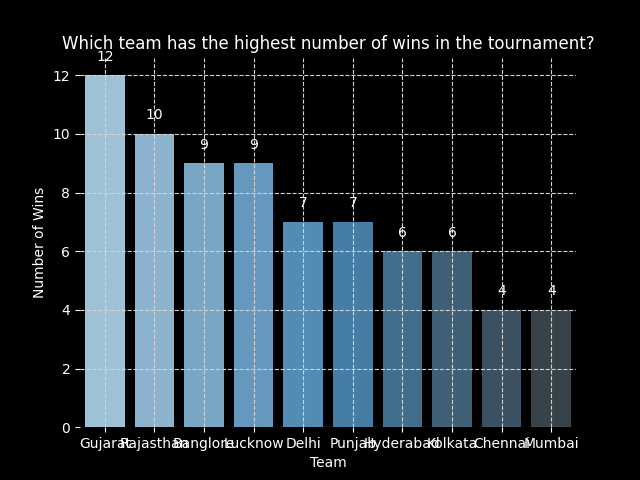

In [5]:
# There are 5 goals above
# Visualizations worked for i=0, 2, 3
i = 0
print(goals[i])

library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)  
charts[0]

Goal(question='What is the distribution of the winning margin in the tournament?', visualization='Histogram of margin column', rationale='This visualization will help us understand the range of winning margins in the tournament and how many matches were won by a large margin and how many were won by a small margin.', index=2)


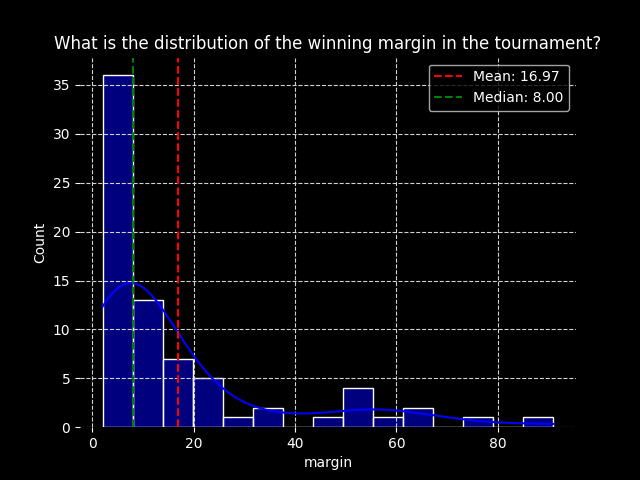

In [6]:
# There are 5 goals above
# Visualizations worked for i=0, 2, 3
i = 2
print(goals[i])

library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)  
charts[0]

Goal(question='Which player has been awarded the most number of player of the match awards?', visualization='Bar chart of player_of_the_match column', rationale="This visualization will help us identify the most valuable player in the tournament who has been consistently performing well and contributing to their team's success.", index=3)


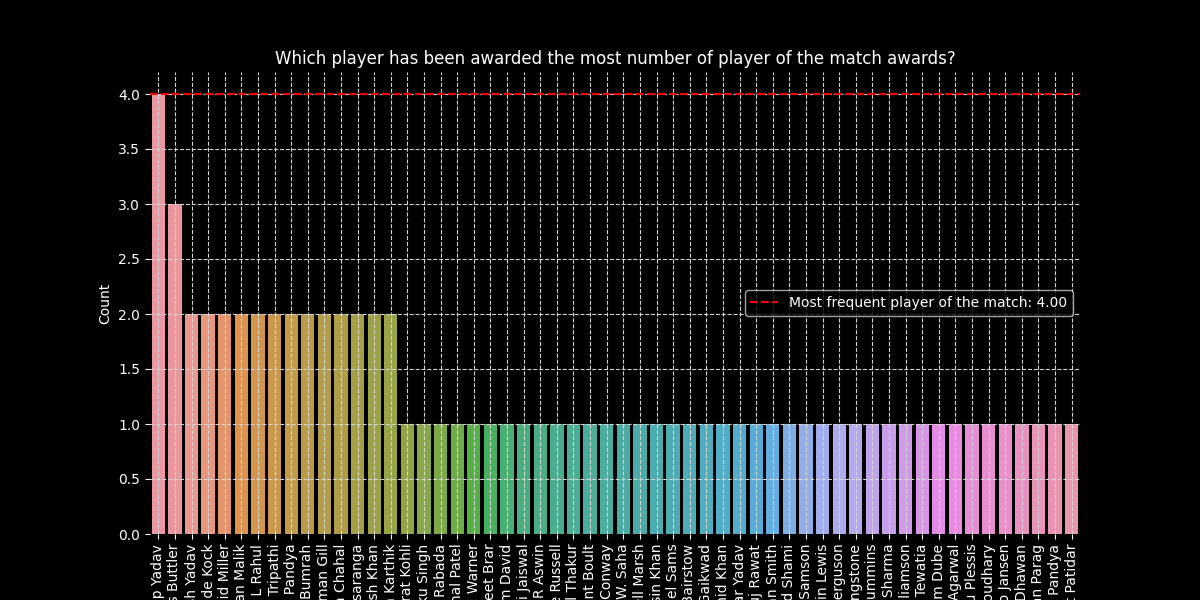

In [7]:
# There are 5 goals above
# Visualizations worked for i=0, 2, 3
i = 3
print(goals[i])

library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)  
charts[0]

### 6.1 Generate visualization via a "user query"   

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

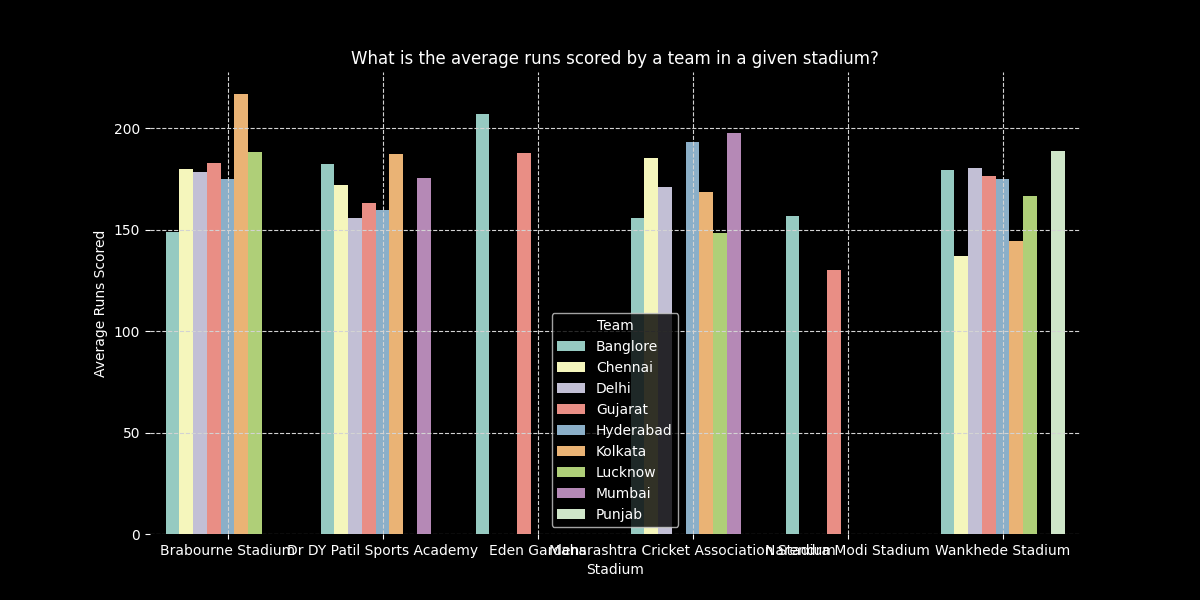

In [28]:
#user_query = "What is the average price of cars by type?"
user_query = "What is the average runs scored by a team in a given stadium?"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)  
charts[0]

<string>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

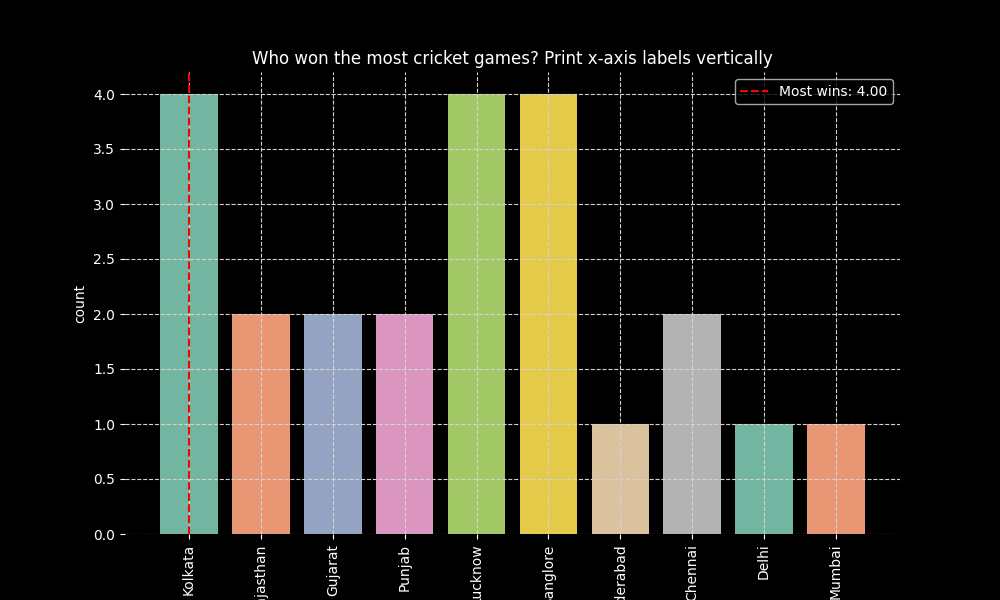

In [27]:
user_query = "Who won the most cricket games?"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)  
charts[0]

# 7. VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



### 7.1 Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

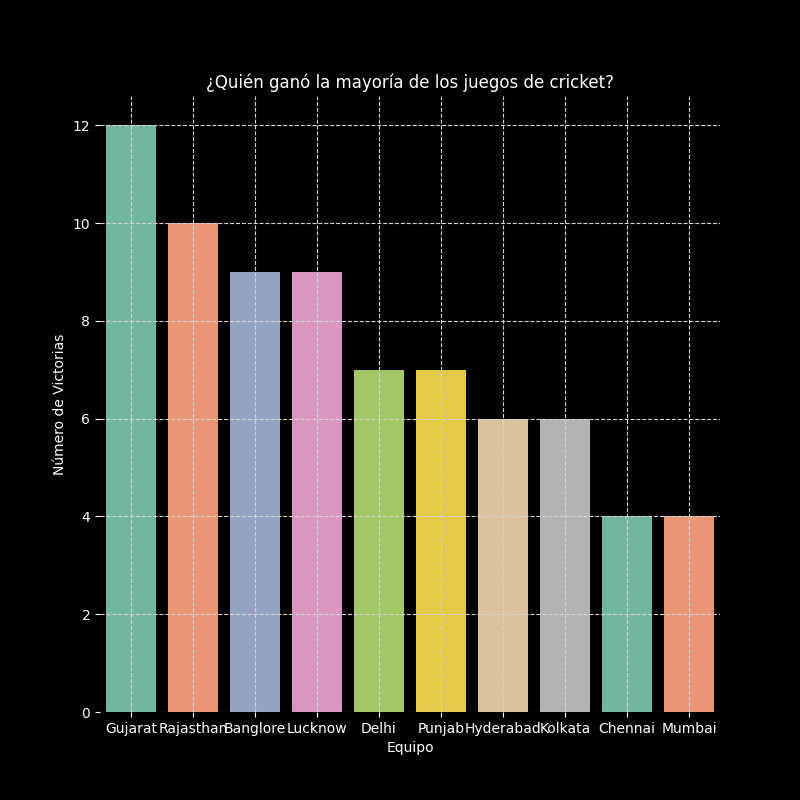

In [10]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["make the chart height and width equal", "change the color of the chart to red", "translate the chart to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
edited_charts[0]

### 7.2 Visualization explanations and accessibility

In [11]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The chart created by the code is a bar chart that shows the number of wins for each cricket team. The chart uses the seaborn library and has a palette of Set2 colors. The goal of the chart is to show which team won the most cricket games.
transformation  **  The code performs two transformations on the data. First, it groups the data by the match_winner column and counts the number of times each team won. Second, it sorts the resulting data in descending order of the number of wins.
visualization  **  The code creates the visualization by using the seaborn barplot function to plot the number of wins for each team. The x-axis shows the team names, and the y-axis shows the number of wins. The chart has a title of 'Who won the most cricket games?' and the x and y-axis are labeled with 'Team' and 'Number of Wins', respectively.


### 7.3 Visualization code self-evaluation and repair

In [12]:
evaluations = lida.evaluate(code=code,  goal=goals[i], textgen_config=textgen_config, library=library)[0] 
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 10 / 10
	 The code is free of bugs, syntax errors, and typos. It is also well-structured and easy to read.
	**********************************
transformation Score 10 / 10
	 The data is appropriately transformed by grouping the data by match_winner and counting the number of times each team won. The resulting data is sorted in descending order of the number of wins.
	**********************************
compliance Score 10 / 10
	 The code meets the specified goal of identifying the player with the most player of the match awards. The bar chart shows the number of wins for each team, and the team with the most wins is the team 
	**********************************
type Score 10 / 10
	 The bar chart is an appropriate visualization type for showing the number of wins for each team. It is easy to read and understand.
	**********************************
encoding Score 10 / 10
	 The data is encoded appropriately by using the x-axis to represent the team and the y-axis to represent th

## Visualization Recommendation

In [13]:
textgen_config = TextGenerationConfig(n=2, temperature=0.2, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

Recommended 2 charts


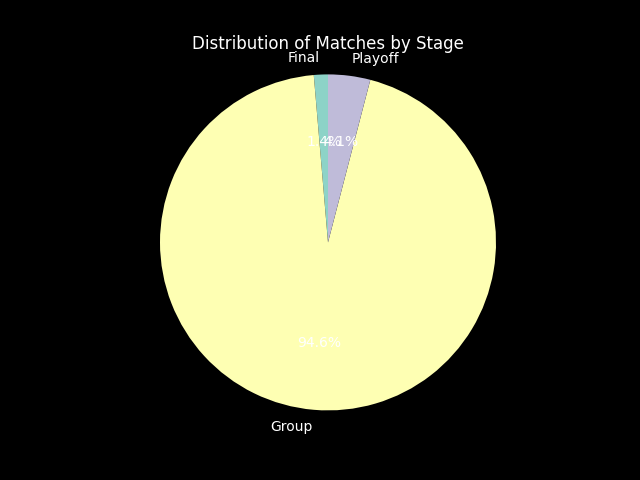

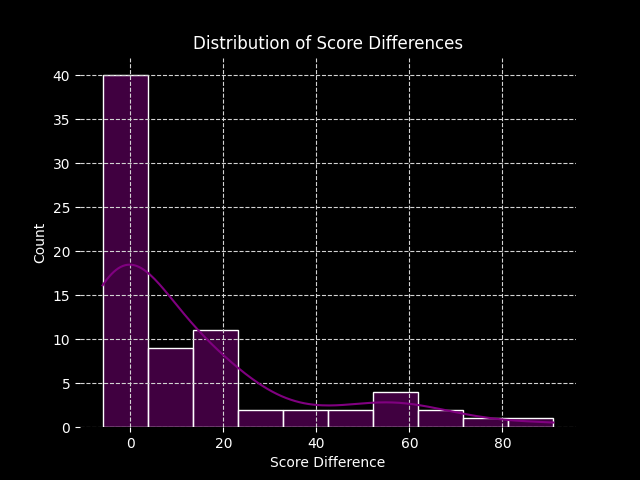

In [14]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    display(chart) 

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [15]:
# !pip install lida[infographics] 
# ensure you have a GPU runtime

In [16]:
# 🚨 | Uncomment below to try it out only if you have access to 
#      a GPU Runtime in your GitHub Codespaces or Docker Desktop

# infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, green pearly rain drops, highly detailed, no blur, white background")

In [17]:
# 🚨 | Uncomment below to try it out only if you have access to 
#      a GPU Runtime in your GitHub Codespaces or Docker Desktop
#      and successfully ran the previous cell
from lida.utils import plot_raster
# plot_raster([edited_charts[0].raster, infographics["images"][0]]) 